In [1]:
# import packages needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler , MinMaxScaler
import math
from torchsummaryX import summary

# To auto load the customise module
%load_ext autoreload
%autoreload 2
import deep_learning_module
import data_module

In [2]:
split_ratio = 0.05
num_epochs = 1
window_size = 5
batch_size = 5
n_step = 2
learning_rate = 0.001

In [3]:
traffic = pd.read_csv(r"C:\Users\vimal\Projects\time-series-labs\datasets\traffic\train_ML_IOT.csv")
traffic.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [4]:
traffic_junction1 = traffic.loc[traffic["Junction"] == 1]
traffic_junction2 = traffic.loc[traffic["Junction"] == 2]
traffic_junction3 = traffic.loc[traffic["Junction"] == 3]
traffic_junction4 = traffic.loc[traffic["Junction"] == 4]

In [5]:
new_traffic = traffic.set_index(pd.to_datetime(traffic["DateTime"]))

In [6]:
new_traffic = new_traffic.drop(columns = ['DateTime','ID'])
new_traffic.head()

,Junction,Vehicles
DateTime,,
2015-11-01 00:00:00,1,15
2015-11-01 01:00:00,1,13
2015-11-01 02:00:00,1,10
2015-11-01 03:00:00,1,7
2015-11-01 04:00:00,1,9


In [7]:
traffic_junction1 = new_traffic.loc[new_traffic["Junction"] == 1]
traffic_junction2 = new_traffic.loc[new_traffic["Junction"] == 2]
traffic_junction3 = new_traffic.loc[new_traffic["Junction"] == 3]
traffic_junction4 = new_traffic.loc[new_traffic["Junction"] == 4]

In [8]:
traffic_merge = traffic_junction1.merge(traffic_junction2,how='left', left_on='DateTime', right_on='DateTime')
traffic_merge.rename(columns={'Vehicles_x': 'Junction_1', 'Vehicles_y': 'Junction_2'}, inplace=True)
traffic_merge = traffic_merge.merge(traffic_junction3,how='left', left_on='DateTime', right_on='DateTime')
traffic_merge = traffic_merge.merge(traffic_junction4,how='left', left_on='DateTime', right_on='DateTime')
traffic_merge.rename(columns={'Vehicles_x': 'Junction_3', 'Vehicles_y': 'Junction_4'}, inplace=True)

In [9]:
traffic_merge = traffic_merge.drop(columns = ['Junction_x','Junction_y'])
traffic_merge.head()

,Junction_1,Junction_2,Junction_3,Junction_4
DateTime,,,,
2015-11-01 00:00:00,15,6,9,NaN
2015-11-01 01:00:00,13,6,7,NaN
2015-11-01 02:00:00,10,5,5,NaN
2015-11-01 03:00:00,7,6,1,NaN
2015-11-01 04:00:00,9,7,2,NaN


In [10]:
traffic_merge['Junction_4'] = traffic_merge['Junction_4'].fillna(0)

In [11]:
traffic_merge['Junction_1'] = traffic_merge['Junction_1'].astype(float)
traffic_merge['Junction_2'] = traffic_merge['Junction_2'].astype(float)
traffic_merge['Junction_3'] = traffic_merge['Junction_3'].astype(float)

In [12]:
traffic_merge.head()

,Junction_1,Junction_2,Junction_3,Junction_4
DateTime,,,,
2015-11-01 00:00:00,15.0,6.0,9.0,0.0
2015-11-01 01:00:00,13.0,6.0,7.0,0.0
2015-11-01 02:00:00,10.0,5.0,5.0,0.0
2015-11-01 03:00:00,7.0,6.0,1.0,0.0
2015-11-01 04:00:00,9.0,7.0,2.0,0.0


<AxesSubplot:xlabel='DateTime'>

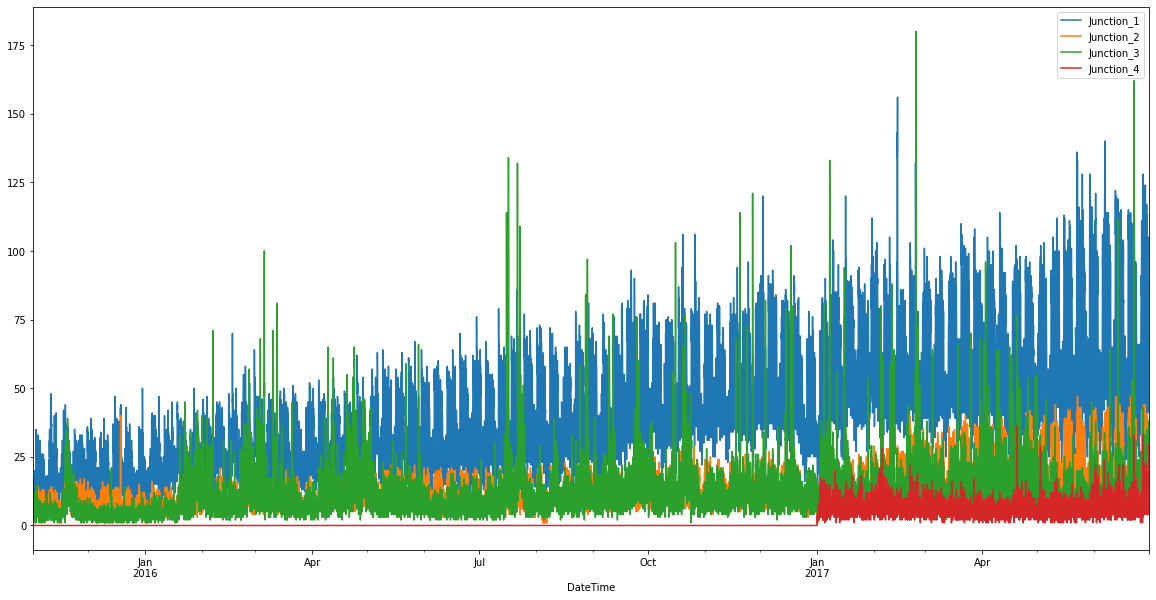

In [13]:
traffic_merge.plot(figsize = (20,10))

In [14]:
split_data = round(len(traffic_merge)*split_ratio)
split_data

730

In [15]:
train_data = traffic_merge[:-split_data]
test_data = traffic_merge[-split_data:]
train_time = traffic_merge.index[:-split_data ]
test_time = traffic_merge.index[-split_data :]

print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(13862, 4)
test_data_shape
(730, 4)


In [16]:
scaler = MinMaxScaler().fit(train_data.values.reshape(-1,1))
train_data_normalized  = scaler.transform(train_data.values.reshape(-1, 1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))
print("train_data_normalized_demand"+str(train_data_normalized.shape))
print("test_data_normalized_demand"+str(test_data_normalized.shape))

train_data_normalized_demand(55448, 1)
test_data_normalized_demand(2920, 1)


In [17]:
train_data_normalized = train_data_normalized.reshape(train_data.shape[0],train_data.shape[1])
print("test_data_normalized"+str(train_data_normalized.shape))

test_data_normalized = test_data_normalized.reshape(test_data.shape[0],test_data.shape[1])
print("test_data_normalized"+str(test_data_normalized.shape))

test_data_normalized(13862, 4)
test_data_normalized(730, 4)


In [18]:
def multivariate_univariate_multi_step(sequence,window_size,n_multistep):
    x, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + window_size
        out_ix = end_ix + n_multistep -1
        # check if we are beyond the sequence
        if out_ix > len(sequence):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix,:], sequence[end_ix-1:out_ix,-1]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

In [19]:
trainX ,trainY=  multivariate_univariate_multi_step(train_data_normalized,window_size,n_step)
testX , testY = multivariate_univariate_multi_step(test_data_normalized,window_size,n_step)
trainY = trainY.reshape(trainY.shape[0],n_step,1)
testY= testY.reshape(testY.shape[0],n_step,1)
print(f"trainX_demand shape:{trainX.shape} trainY_demand shape:{trainY.shape}\n")
print(f"testX_demand shape:{testX.shape} testY_demand shape:{testY.shape}")


trainX_demand shape:(13857, 5, 4) trainY_demand shape:(13857, 2, 1)

testX_demand shape:(725, 5, 4) testY_demand shape:(725, 2, 1)


In [20]:
train_data_dict ,test_data_dict = data_module.key_assign(trainingX = trainX  , 
                       testingX = testX, 
                       trainingY = trainY, 
                       testingY = testY)
train_data_dict ,test_data_dict = data_module.transform(train_data_dict ,test_data_dict)

In [21]:
data_module.sanity_check(train_data_dict , test_data_dict)

train_data_x_feature shape : torch.Size([13857, 5, 4])
train_data_y_label shape : torch.Size([13857, 2, 1])
test_data_x_feature shape : torch.Size([725, 5, 4])
test_data_y_label shape : torch.Size([725, 2, 1])


In [22]:
train_iter , test_iter = data_module.iterator(train_data_dict ,
                                                          test_data_dict,
                                                          batch_size = batch_size)

In [23]:
torch.manual_seed(123)
#Arguments for LSTM model
hidden_dim = 32
n_feature = trainX.shape[2] 
#1 for vanila LSTM , >1 is mean stacked LSTM
num_layers = 1
#Vanilla , Stacked LSTM
model = deep_learning_module.LSTM(n_feature = n_feature, 
                                        hidden_dim = hidden_dim ,
                                        num_layers = num_layers , 
                                        n_step = n_step )

In [24]:
#loss function 
loss_fn = torch.nn.MSELoss()
#optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
inputs = torch.zeros((batch_size,window_size,trainX.shape[2]),dtype=torch.float)
print(summary(model,inputs))

       Kernel Shape Output Shape  Params  Mult-Adds
Layer                                              
0_lstm            -   [5, 5, 32]    4864       4608
1_fc        [32, 2]       [5, 2]      66         64
---------------------------------------------------
                      Totals
Total params            4930
Trainable params        4930
Non-trainable params       0
Mult-Adds               4672
       Kernel Shape Output Shape  Params  Mult-Adds
Layer                                              
0_lstm            -   [5, 5, 32]    4864       4608
1_fc        [32, 2]       [5, 2]      66         64


In [26]:
torch.manual_seed(123)
# Start training 
train_loss,val_loss = deep_learning_module.training(num_epochs= num_epochs ,
                                                    train_iter = train_iter,
                                                    test_iter = test_iter ,
                                                    optimizer = optimizer,
                                                    loss_fn = loss_fn,
                                                    model = model)

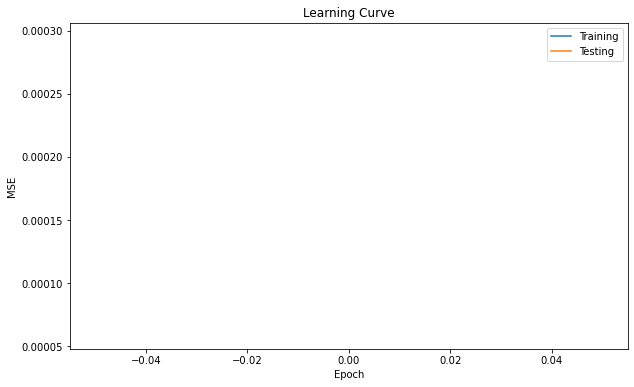

Epoch : 0 , training loss : 5.958170804027974e-05 , validation loss : 0.0002947579449780811


In [27]:
data_module.learning_curve(num_epochs = num_epochs,
                           train_loss = train_loss ,
                           val_loss = val_loss)

In [28]:
with torch.no_grad():
    y_train_prediction = model(train_data_dict['train_data_x_feature'])
    y_test_prediction = model(test_data_dict['test_data_x_feature'])

In [29]:
prediction , output = data_module.key_assign_evaluation(y_train_prediction,
                                                                    y_test_prediction,
                                                                    train_data_dict,
                                                                    test_data_dict)

In [30]:
output_data = data_module.squeeze_dimension(output)

In [31]:
data_module.sanity_check(data_1 = output_data,data_2 = {})

train_data_output shape : torch.Size([13857, 2])
test_data_output shape : torch.Size([725, 2])


In [32]:
prediction = data_module.inverse_scaler(prediction,scaler)
output_data  = data_module.inverse_scaler(output_data ,scaler)

In [33]:
prediction['test_data_prediction'] = np.rint(prediction['test_data_prediction'])
output_data['test_data_output'] =  np.rint(output_data['test_data_output']) 

In [34]:
#data_module.list_forecast_value(output_data,prediction) 

In [35]:
trainScore,testScore = data_module.rmse(prediction,output_data)
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.52 RMSE
Test Score: 3.11 RMSE


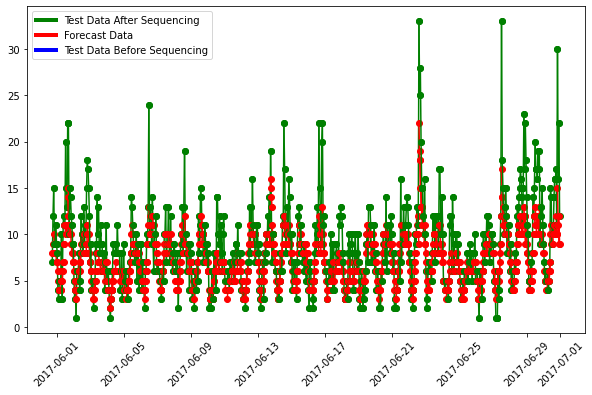

In [36]:
data_module.multi_step_plot(original_test_data = test_data["Junction_4"],
                            after_sequence_test_data = output_data,
                            forecast_data = prediction,
                            test_time = test_time,
                            window_size = window_size,
                            n_step = n_step,
                            details={},
                            original_plot=False,
                            multivariate = True)

Junction 3

In [37]:
traffic_merge = traffic_merge[['Junction_4', 'Junction_1', 'Junction_2', 'Junction_3']]
traffic_merge.head()

,Junction_4,Junction_1,Junction_2,Junction_3
DateTime,,,,
2015-11-01 00:00:00,0.0,15.0,6.0,9.0
2015-11-01 01:00:00,0.0,13.0,6.0,7.0
2015-11-01 02:00:00,0.0,10.0,5.0,5.0
2015-11-01 03:00:00,0.0,7.0,6.0,1.0
2015-11-01 04:00:00,0.0,9.0,7.0,2.0


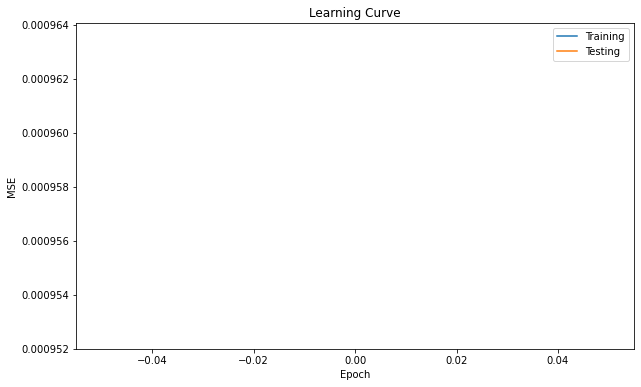

Epoch : 0 , training loss : 0.0009635260931027055 , validation loss : 0.000952543526301301
Train Score: 4.01 RMSE
Test Score: 5.57 RMSE


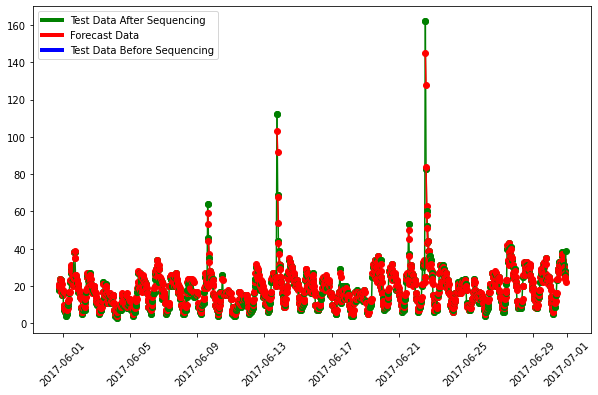

In [38]:
train_data = traffic_merge[:-split_data]
test_data = traffic_merge[-split_data:]
train_time = traffic_merge.index[:-split_data ]
test_time = traffic_merge.index[-split_data :]

scaler = MinMaxScaler().fit(train_data.values.reshape(-1,1))
train_data_normalized  = scaler.transform(train_data.values.reshape(-1, 1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

train_data_normalized = train_data_normalized.reshape(train_data.shape[0],train_data.shape[1])
test_data_normalized = test_data_normalized.reshape(test_data.shape[0],test_data.shape[1])

trainX ,trainY=  multivariate_univariate_multi_step(train_data_normalized,window_size,n_step)
testX , testY = multivariate_univariate_multi_step(test_data_normalized,window_size,n_step)
trainY = trainY.reshape(trainY.shape[0],n_step,1)
testY= testY.reshape(testY.shape[0],n_step,1)

train_data_dict ,test_data_dict = data_module.key_assign(trainingX = trainX  , 
                       testingX = testX, 
                       trainingY = trainY, 
                       testingY = testY)
train_data_dict ,test_data_dict = data_module.transform(train_data_dict ,test_data_dict)

train_iter , test_iter = data_module.iterator(train_data_dict ,
                                                          test_data_dict,
                                                          batch_size = batch_size)

torch.manual_seed(123)
#Arguments for LSTM model
hidden_dim = 32
n_feature = trainX.shape[2] 
#1 for vanila LSTM , >1 is mean stacked LSTM
num_layers = 1
#Vanilla , Stacked LSTM
model3 = deep_learning_module.LSTM(n_feature = n_feature, 
                                        hidden_dim = hidden_dim ,
                                        num_layers = num_layers , 
                                        n_step = n_step )
#loss function 
loss_fn = torch.nn.MSELoss()
#optimiser
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)
inputs = torch.zeros((batch_size,window_size,trainX.shape[2]),dtype=torch.float)
torch.manual_seed(123)
# Start training 
train_loss,val_loss = deep_learning_module.training(num_epochs= num_epochs ,
                                                    train_iter = train_iter,
                                                    test_iter = test_iter ,
                                                    optimizer = optimizer,
                                                    loss_fn = loss_fn,
                                                    model = model3)
data_module.learning_curve(num_epochs = num_epochs,
                           train_loss = train_loss ,
                           val_loss = val_loss)
with torch.no_grad():
    y_train_prediction = model3(train_data_dict['train_data_x_feature'])
    y_test_prediction = model3(test_data_dict['test_data_x_feature'])
    
prediction , output = data_module.key_assign_evaluation(y_train_prediction,
                                                                    y_test_prediction,
                                                                    train_data_dict,
                                                                    test_data_dict)
output_data = data_module.squeeze_dimension(output)

prediction = data_module.inverse_scaler(prediction,scaler)
output_data  = data_module.inverse_scaler(output_data ,scaler)

prediction['test_data_prediction'] = np.rint(prediction['test_data_prediction'])
output_data['test_data_output'] =  np.rint(output_data['test_data_output']) 

trainScore,testScore = data_module.rmse(prediction,output_data)

data_module.multi_step_plot(original_test_data = test_data["Junction_3"],
                            after_sequence_test_data = output_data,
                            forecast_data = prediction,
                            test_time = test_time,
                            window_size = window_size,
                            n_step = n_step,
                            details={},
                            original_plot=False,
                            multivariate = True)
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Junction 2

In [39]:
traffic_merge = traffic_merge[['Junction_3', 'Junction_4', 'Junction_1', 'Junction_2']]
traffic_merge.head()

,Junction_3,Junction_4,Junction_1,Junction_2
DateTime,,,,
2015-11-01 00:00:00,9.0,0.0,15.0,6.0
2015-11-01 01:00:00,7.0,0.0,13.0,6.0
2015-11-01 02:00:00,5.0,0.0,10.0,5.0
2015-11-01 03:00:00,1.0,0.0,7.0,6.0
2015-11-01 04:00:00,2.0,0.0,9.0,7.0


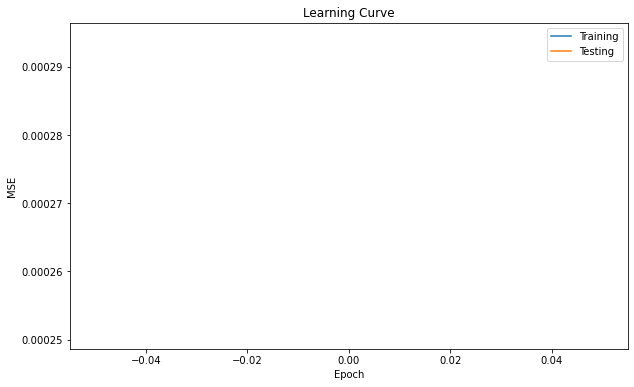

Epoch : 0 , training loss : 0.0002508366693540579 , validation loss : 0.0002943203224276658
Train Score: 3.75 RMSE
Test Score: 3.11 RMSE


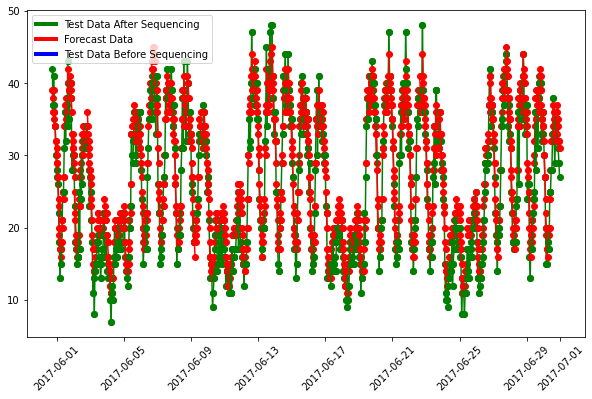

In [40]:
train_data = traffic_merge[:-split_data]
test_data = traffic_merge[-split_data:]
train_time = traffic_merge.index[:-split_data ]
test_time = traffic_merge.index[-split_data :]

scaler = MinMaxScaler().fit(train_data.values.reshape(-1,1))
train_data_normalized  = scaler.transform(train_data.values.reshape(-1, 1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

train_data_normalized = train_data_normalized.reshape(train_data.shape[0],train_data.shape[1])
test_data_normalized = test_data_normalized.reshape(test_data.shape[0],test_data.shape[1])

trainX ,trainY=  multivariate_univariate_multi_step(train_data_normalized,window_size,n_step)
testX , testY = multivariate_univariate_multi_step(test_data_normalized,window_size,n_step)
trainY = trainY.reshape(trainY.shape[0],n_step,1)
testY= testY.reshape(testY.shape[0],n_step,1)

train_data_dict ,test_data_dict = data_module.key_assign(trainingX = trainX  , 
                       testingX = testX, 
                       trainingY = trainY, 
                       testingY = testY)
train_data_dict ,test_data_dict = data_module.transform(train_data_dict ,test_data_dict)

train_iter , test_iter = data_module.iterator(train_data_dict ,
                                                          test_data_dict,
                                                          batch_size = batch_size)

torch.manual_seed(123)
#Arguments for LSTM model
hidden_dim = 32
n_feature = trainX.shape[2] 
#1 for vanila LSTM , >1 is mean stacked LSTM
num_layers = 1
#Vanilla , Stacked LSTM
model2 = deep_learning_module.LSTM(n_feature = n_feature, 
                                        hidden_dim = hidden_dim ,
                                        num_layers = num_layers , 
                                        n_step = n_step )
#loss function 
loss_fn = torch.nn.MSELoss()
#optimiser
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
inputs = torch.zeros((batch_size,window_size,trainX.shape[2]),dtype=torch.float)
torch.manual_seed(123)
# Start training 
train_loss,val_loss = deep_learning_module.training(num_epochs= num_epochs ,
                                                    train_iter = train_iter,
                                                    test_iter = test_iter ,
                                                    optimizer = optimizer,
                                                    loss_fn = loss_fn,
                                                    model = model2)
data_module.learning_curve(num_epochs = num_epochs,
                           train_loss = train_loss ,
                           val_loss = val_loss)
with torch.no_grad():
    y_train_prediction = model2(train_data_dict['train_data_x_feature'])
    y_test_prediction = model2(test_data_dict['test_data_x_feature'])
    
prediction , output = data_module.key_assign_evaluation(y_train_prediction,
                                                                    y_test_prediction,
                                                                    train_data_dict,
                                                                    test_data_dict)
output_data = data_module.squeeze_dimension(output)

prediction = data_module.inverse_scaler(prediction,scaler)
output_data  = data_module.inverse_scaler(output_data ,scaler)

prediction['test_data_prediction'] = np.rint(prediction['test_data_prediction'])
output_data['test_data_output'] =  np.rint(output_data['test_data_output']) 

trainScore,testScore = data_module.rmse(prediction,output_data)

data_module.multi_step_plot(original_test_data = test_data["Junction_2"],
                            after_sequence_test_data = output_data,
                            forecast_data = prediction,
                            test_time = test_time,
                            window_size = window_size,
                            n_step = n_step,
                            details={},
                            original_plot=False,
                            multivariate = True)
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Junction 1

In [41]:
traffic_merge = traffic_merge[['Junction_2', 'Junction_3', 'Junction_4', 'Junction_1']]
traffic_merge.head()

,Junction_2,Junction_3,Junction_4,Junction_1
DateTime,,,,
2015-11-01 00:00:00,6.0,9.0,0.0,15.0
2015-11-01 01:00:00,6.0,7.0,0.0,13.0
2015-11-01 02:00:00,5.0,5.0,0.0,10.0
2015-11-01 03:00:00,6.0,1.0,0.0,7.0
2015-11-01 04:00:00,7.0,2.0,0.0,9.0


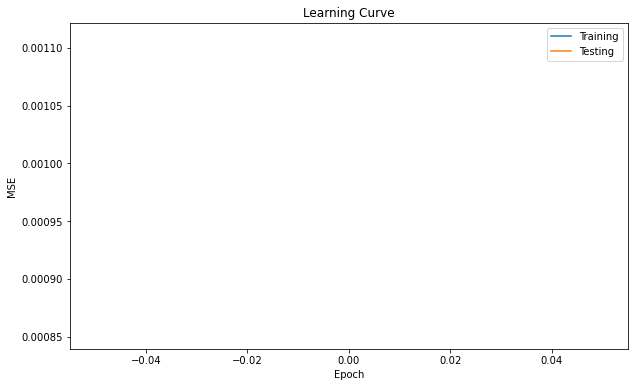

Epoch : 0 , training loss : 0.001108862943888024 , validation loss : 0.0008523689721939797
Train Score: 5.71 RMSE
Test Score: 5.26 RMSE


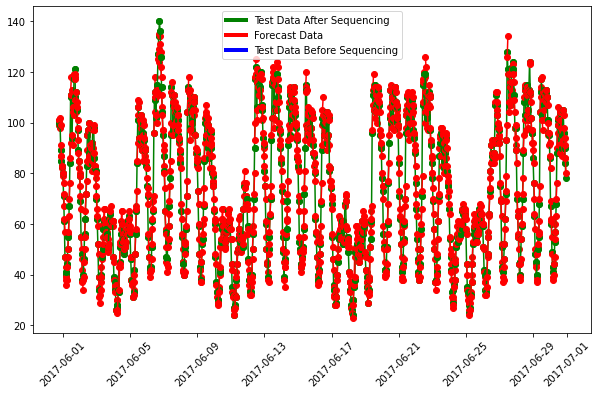

In [42]:
train_data = traffic_merge[:-split_data]
test_data = traffic_merge[-split_data:]
train_time = traffic_merge.index[:-split_data ]
test_time = traffic_merge.index[-split_data :]

scaler = MinMaxScaler().fit(train_data.values.reshape(-1,1))
train_data_normalized  = scaler.transform(train_data.values.reshape(-1, 1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

train_data_normalized = train_data_normalized.reshape(train_data.shape[0],train_data.shape[1])
test_data_normalized = test_data_normalized.reshape(test_data.shape[0],test_data.shape[1])

trainX ,trainY=  multivariate_univariate_multi_step(train_data_normalized,window_size,n_step)
testX , testY = multivariate_univariate_multi_step(test_data_normalized,window_size,n_step)
trainY = trainY.reshape(trainY.shape[0],n_step,1)
testY= testY.reshape(testY.shape[0],n_step,1)

train_data_dict ,test_data_dict = data_module.key_assign(trainingX = trainX  , 
                       testingX = testX, 
                       trainingY = trainY, 
                       testingY = testY)
train_data_dict ,test_data_dict = data_module.transform(train_data_dict ,test_data_dict)

train_iter , test_iter = data_module.iterator(train_data_dict ,
                                                          test_data_dict,
                                                          batch_size = batch_size)

torch.manual_seed(123)
#Arguments for LSTM model
hidden_dim = 32
n_feature = trainX.shape[2] 
#1 for vanila LSTM , >1 is mean stacked LSTM
num_layers = 1
#Vanilla , Stacked LSTM
model1 = deep_learning_module.LSTM(n_feature = n_feature, 
                                        hidden_dim = hidden_dim ,
                                        num_layers = num_layers , 
                                        n_step = n_step )
#loss function 
loss_fn = torch.nn.MSELoss()
#optimiser
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)
inputs = torch.zeros((batch_size,window_size,trainX.shape[2]),dtype=torch.float)
torch.manual_seed(123)
# Start training 
train_loss,val_loss = deep_learning_module.training(num_epochs= num_epochs ,
                                                    train_iter = train_iter,
                                                    test_iter = test_iter ,
                                                    optimizer = optimizer,
                                                    loss_fn = loss_fn,
                                                    model = model1)
data_module.learning_curve(num_epochs = num_epochs,
                           train_loss = train_loss ,
                           val_loss = val_loss)
with torch.no_grad():
    y_train_prediction = model1(train_data_dict['train_data_x_feature'])
    y_test_prediction = model1(test_data_dict['test_data_x_feature'])
    
prediction , output = data_module.key_assign_evaluation(y_train_prediction,
                                                                    y_test_prediction,
                                                                    train_data_dict,
                                                                    test_data_dict)
output_data = data_module.squeeze_dimension(output)

prediction = data_module.inverse_scaler(prediction,scaler)
output_data  = data_module.inverse_scaler(output_data ,scaler)

prediction['test_data_prediction'] = np.rint(prediction['test_data_prediction'])
output_data['test_data_output'] =  np.rint(output_data['test_data_output']) 

trainScore,testScore = data_module.rmse(prediction,output_data)

data_module.multi_step_plot(original_test_data = test_data["Junction_2"],
                            after_sequence_test_data = output_data,
                            forecast_data = prediction,
                            test_time = test_time,
                            window_size = window_size,
                            n_step = n_step,
                            details={},
                            original_plot=False,
                            multivariate = True)
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))